In [1]:
import os
import time
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


torch.Size([3, 64, 64])


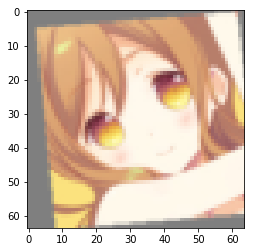

64 100


In [2]:
if not os.path.exists('./previews'):
    os.makedirs('./previews')
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_class = 6
n_class_remap = 18
batch_size = 32
n_dim = 128
n_feature = 110
n_ch = 3
g_feature_map_b = 128
d_feature_map_b = 128

fold_dataset = datasets.ImageFolder('/hdd/dataset/pixiv_face_tagged', 
                       transform=transforms.Compose([
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomAffine(5, translate=(0.05,0.05), scale=(0.9,1.1), shear=2, resample=2, fillcolor=tuple([127]*n_ch)),
                           transforms.Resize([n_dim]*2, interpolation=2),
                           transforms.ToTensor(), # normalize to [0,1]
                           transforms.Normalize([0.5]*n_ch, [0.5]*n_ch) # [0,1] -> [-1,+1]
                       ]))


print(fold_dataset.__getitem__(100)[0].shape)
plt.imshow(np.squeeze(np.clip(np.array(fold_dataset.__getitem__(100)[0]).transpose(1,2,0)*127.5+127.5,0,255).astype(np.uint8)))
plt.show()
data_loader = torch.utils.data.DataLoader(
        fold_dataset,
        batch_size=batch_size, shuffle=True, num_workers=4)
print(n_dim, n_feature)
def inf_data_gen():
    while True:
        for data, label in data_loader:
            yield data, label
gen = inf_data_gen()

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data)

def one_hot(ids, n_class):
    if len(ids.size())==2:
        return ids
    ohe = torch.FloatTensor(ids.size(0), n_class, device="cpu")
    ids = ids.view(-1,1)
    ohe.zero_()
    ohe.scatter_(1, ids, 1)
    return ohe

def gradient_penalty_loss(C, real, fake, label, lambda_, device):
    w = torch.rand(real.size(0), 1, 1, 1, device=device).expand_as(real)
    x_hat = w*real + (1-w)*fake
    x_hat_g = torch.autograd.Variable(x_hat, requires_grad=True)
    D_x_hat_g = C(x_hat_g, label)
    gradients = torch.autograd.grad(outputs=D_x_hat_g, inputs=x_hat_g,
                              grad_outputs=torch.ones_like(D_x_hat_g, device=device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_
    return gradient_penalty

def soft_consistency_loss(C, r1, l1, lambda_, M, device):
    r2 = torch.cat((r1[-1:], r1[:-1]), 0)
    l2 = torch.cat((l1[-1:], l1[:-1]), 0)
    C_r1 , C_r2 = C(r1,l1).view(r1.size(0), 1) , C(r2,l2).view(r2.size(0), 1)
    r1_f , r2_f = r1.view(r1.size(0), -1) , r2.view(r2.size(0), -1)
    return ( (C_r1-C_r2).norm(2, dim=1) / (r1_f-r2_f).norm(2, dim=1) - M ).clamp(min=0) # hinge???????

class C(nn.Module):
    def __init__(self, N_DIM, N_CH, BASE_FEATURE_N=32, N_CLASS=1, N_EMBEDDING=1):
        super(C, self).__init__()
        self.n_dim = N_DIM
        self.n_ch  = N_CH
        self.n_class = N_CLASS
        self.n_emb = N_EMBEDDING
        self.base_f = BASE_FEATURE_N
        self.aux   = nn.Linear(self.n_class, self.n_emb, bias=False)
        self.lrelu = nn.LeakyReLU(0.2)
        self.conv_head = nn.Conv2d(self.n_ch+self.n_emb, self.base_f, 3, stride=1, padding=1, bias=False) 
        self.conv1 = nn.Conv2d(self.base_f, self.base_f, 3, stride=2, padding=1, bias=False) 
        self.conv2 = nn.Conv2d(self.base_f, self.base_f*2, 3, stride=2, padding=1, bias=False) 
        self.in2   = nn.InstanceNorm2d(self.base_f*2)
        self.conv2_1 = nn.Conv2d(self.base_f*2, self.base_f*2, 3, stride=1, padding=1, bias=False) 
        self.in2_1   = nn.InstanceNorm2d(self.base_f*2)
        self.conv3 = nn.Conv2d(self.base_f*2+self.n_emb, self.base_f*4, 3, stride=2, padding=1, bias=False) 
        self.in3   = nn.InstanceNorm2d(self.base_f*4)
        self.conv4 = nn.Conv2d(self.base_f*4, self.base_f*4, 3, stride=2, padding=1, bias=False) 
        self.in4   = nn.InstanceNorm2d(self.base_f*4)
        self.conv5 = nn.Conv2d(self.base_f*4, self.base_f*8, 3, stride=1, padding=1, bias=False) 
        self.in5   = nn.InstanceNorm2d(self.base_f*8)
        self.fc1   = nn.Conv2d(self.base_f*8, 1, self.n_dim//16, stride=1, padding=0, bias=False)
    def forward(self, x, label):
        
        label_emb   = self.aux(label)
        label_ohe2d = label_emb.view(label_emb.size(0), label_emb.size(1), 1, 1)
        
        x = torch.cat((x, label_ohe2d.expand(label_emb.size(0),label_emb.size(1),x.size(2),x.size(3))), 1)
        x = self.conv_head(x) 
        x = self.lrelu(x)
        x = self.conv1(x) 
        x = self.lrelu(x)
        
        x = self.conv2(x) 
        x = self.in2(x) 
        x = self.lrelu(x)
        x = self.conv2_1(x) 
        x = self.in2_1(x) 
        x = self.lrelu(x)
        
        x = torch.cat((x, label_ohe2d.expand(label_emb.size(0),label_emb.size(1),x.size(2),x.size(3))), 1)
        x = self.conv3(x) 
        x = self.in3(x)
        x = self.lrelu(x)
        
        x = self.conv4(x) 
        x = self.in4(x)
        x = self.lrelu(x)
        
        x = self.conv5(x) 
        x = self.in5(x)
        x = self.lrelu(x)
        
        x = self.fc1(x) 
        x = x.view(x.size(0), 1) 
        return x

class G(nn.Module):
    def __init__(self, N_DIM, N_FEATURE, N_CH, BASE_FEATURE_N=32, N_CLASS=1, N_EMB=1):
        super(G, self).__init__()
        self.n_dim = N_DIM
        self.n_ch  = N_CH
        self.n_class = N_CLASS
        self.base_f = BASE_FEATURE_N
        self.n_feature = N_FEATURE
        self.n_emb = N_EMB
        self.aux   = nn.Linear(self.n_class, self.n_emb, bias=False)
        self.conv_head = nn.Conv2d((self.n_emb+self.n_feature)//((self.n_dim//32)**2), self.base_f*8, 3, stride=1, padding=1, bias=False) 
        self.up1   = nn.PixelShuffle(2)
        self.conv1 = nn.Conv2d(self.base_f*2, self.base_f*4, 3, stride=1, padding=1, bias=False) 
        self.in1   = nn.InstanceNorm2d(self.base_f*4)
        self.conv1_1 = nn.Conv2d(self.base_f*4, self.base_f*4, 3, stride=1, padding=1, bias=False) 
        self.in1_1   = nn.InstanceNorm2d(self.base_f*4)
        self.up2   = nn.PixelShuffle(2)
        self.conv2 = nn.Conv2d(self.base_f, self.base_f*2, 3, stride=1, padding=1, bias=False) 
        self.in2   = nn.InstanceNorm2d(self.base_f*2)
        self.conv2_1 = nn.Conv2d(self.base_f*2, self.base_f*2, 3, stride=1, padding=1, bias=False) 
        self.in2_1   = nn.InstanceNorm2d(self.base_f*2)
        self.up3   = nn.PixelShuffle(2)
        self.conv3 = nn.Conv2d(self.base_f//2, self.base_f, 3, stride=1, padding=1, bias=False) 
        self.in3   = nn.InstanceNorm2d(self.base_f)
        self.up4   = nn.PixelShuffle(2)
        self.conv4 = nn.Conv2d(self.base_f//4, self.base_f, 3, stride=1, padding=1, bias=False) 
        self.in4   = nn.InstanceNorm2d(self.base_f)
        self.up5   = nn.PixelShuffle(2)
        self.conv5 = nn.Conv2d(self.base_f//4, self.n_ch, 3, stride=1, padding=1, bias=False) 
    def forward(self, x, label):
        label_emb = self.aux(label)
        x = torch.cat((x, label_emb), 1)
        x = x.view(x.size(0), x.size(1)//((self.n_dim//32)**2), (self.n_dim//32), (self.n_dim//32)) 
        
        x = self.conv_head(x)
        x = self.up1(x)
        x = self.conv1(x) 
        x = self.in1(x) 
        x = F.relu(x)
        s = x
        x = self.conv1_1(x) 
        x = x + s
        x = self.in1_1(x) 
        x = F.relu(x)
        
        x = self.up2(x)
        x = self.conv2(x)  
        x = self.in2(x)
        x = F.relu(x)
        s = x
        x = self.conv2_1(x)  
        x = x + s
        x = self.in2_1(x)
        x = F.relu(x)
        
        x = self.up3(x)
        x = self.conv3(x)  
        x = self.in3(x)
        x = F.relu(x)
        
        x = self.up4(x)
        x = self.conv4(x) 
        x = self.in4(x)
        x = F.relu(x)
        
        x = self.up5(x)
        x = self.conv5(x)  
        x = torch.tanh(x)
        return x

def D(C, r, f, l):
    return C(r,l) - C(f,l).mean()

def gradient_penalty_loss(C, real, fake, label, lambda_, device):
    w = torch.rand(real.size(0), 1, 1, 1, device=device).expand_as(real)
    x_hat = w*real + (1-w)*fake
    x_hat_g = torch.autograd.Variable(x_hat, requires_grad=True)
    D_x_hat_g = C(x_hat_g, label)
    gradients = torch.autograd.grad(outputs=D_x_hat_g, inputs=x_hat_g,
                              grad_outputs=torch.ones_like(D_x_hat_g, device=device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_
    return gradient_penalty

In [4]:
def plot2dir(directory='./previews', imgs=None, iter_n=0):
    imgs = np.clip(np.round((np.concatenate(tuple(imgs.transpose(0,2,3,1)), axis=0)+1)*127.5), 0, 255).astype(np.uint8) # (?, 28, 28)
    cv2.imwrite('{}/{:08d}.jpg'.format(directory, iter_n), np.squeeze(imgs[...,::-1])) # RGB->BGR
    

In [5]:
seed = 3 # debug!!!
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
G_net = G(n_dim, n_feature, n_ch, g_feature_map_b, n_class, n_class_remap).to(device).apply(weights_init)
C_net = C(n_dim, n_ch, d_feature_map_b, n_class, n_class_remap).to(device).apply(weights_init)
opt_C = optim.Adam(C_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_G = optim.Adam(G_net.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [6]:
from tqdm import tqdm_notebook

iterations = 500000
preview_iter = 500
# max_preview_imgs = 5
d_iter = 1
std = 1.0
lambda_1 , lambda_2 = 10 , 0.2
M = 0.05
exp_replay_maxl = 200
exp_replay = deque(maxlen=exp_replay_maxl)

for ite in tqdm_notebook(range(1, iterations+1)):
    start_train_ts = time.time()
    # train D:
    G_net.eval()
    C_net.train()
    d_loss_mean = []
    g_loss_mean = 0.0
    for _ in range(d_iter):
        opt_C.zero_grad()
        real, label = next(gen)
        real = real.to(device)
        label = one_hot(label, n_class).to(device)
        sample = torch.randn(real.size(0), n_feature, device=device).clamp(-2,2) * std
        fake   = G_net(sample, label).detach() # not to touch G_net
        d_loss_real = ( 1-D(C_net, real,fake,label) ).clamp(min=0).mean()
        d_loss_real.backward()
        d_loss_fake = ( 1+D(C_net, fake,real,label) ).clamp(min=0).mean()
        d_loss_fake.backward()
        d_loss = d_loss_real + d_loss_fake # + d_loss_gp
        opt_C.step()
        d_loss_mean.append(d_loss.item())
        exp_replay.append(( real.detach().cpu(), label.detach().cpu(), sample.detach().cpu(), fake.detach().cpu() ))
    if len(exp_replay)>=exp_replay_maxl and np.random.rand()<0.2:
        opt_C.zero_grad()
        idx = np.random.randint(len(exp_replay))
        real_, label_, sample_, fake_ = exp_replay[idx]
        real_ = real_.to(device)
        label_= label_.to(device)
        sample_ = sample_.to(device)
        fake_ = fake_.to(device)
        d_loss_real = ( 1-D(C_net, real_,fake_,label_) ).clamp(min=0).mean()
        d_loss_real.backward()
        d_loss_fake = ( 1+D(C_net, fake_,real_,label_) ).clamp(min=0).mean()
        d_loss_fake.backward()
        d_loss = d_loss_real + d_loss_fake # + d_loss_gp
        opt_C.step()
        d_loss_mean.append(d_loss.item())
    d_loss_mean = np.mean(d_loss_mean)
    D_update_ts = time.time()
    # train G:
    real, label = next(gen)
    real = real.to(device)
    label = one_hot(label, n_class).to(device)
    G_net.train()
    C_net.eval()
    opt_G.zero_grad()
    sample = torch.randn(real.size(0), n_feature, device=device).clamp(-2,2) * std
    generated = G_net(sample, label)
    g_loss = ( 1-D(C_net, generated,real,label) ).clamp(min=0).mean() + ( 1+D(C_net, real,generated,label) ).clamp(min=0).mean()
    g_loss.backward()
    opt_G.step()
    g_loss_mean = g_loss.mean().item()
    G_update_ts = time.time()
    if ite%preview_iter==0:
        print('[{}/{}] G: {:.4f}, D:{:.4f} -- elapsed_G: {:.4f}s -- elapsed_D: {:.4f}s'.format(ite, iterations, g_loss_mean, d_loss_mean, (G_update_ts-D_update_ts), (D_update_ts-start_train_ts) ))
        
        imgs = []
        for c in range(n_class):
            sample = torch.randn(1, n_feature, device=device).clamp(-2,2) * std
            label  = one_hot(torch.LongTensor([c], device="cpu"), n_class).to(device)
            generated = G_net(sample, label).detach().cpu().numpy()[0]
            imgs.append(generated)
        imgs = np.asarray(imgs)
        
        plot2dir('./previews', imgs, ite)
        torch.save(G_net.state_dict(), './checkpoints/iter-{:d}-G.ckpt'.format(ite))
        torch.save(C_net.state_dict(), './checkpoints/iter-{:d}-D.ckpt'.format(ite))

[200/10000] G: 36.0840, D:0.0000 -- elapsed_G: 0.1423s -- elapsed_D: 0.1670s


KeyboardInterrupt: 